# XGBoost

Vamos a ver qué tal funciona el XGBoost con el problema de la predicción de acciones en bolsa.

In [48]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv

--2021-04-18 19:13:06--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6220 (6.1K) [text/plain]
Saving to: ‘daily-total-female-births.csv.1’

daily-total-female- 100%[===================>]   6.07K  --.-KB/s    in 0s      

2021-04-18 19:13:07 (69.1 MB/s) - ‘daily-total-female-births.csv.1’ saved [6220/6220]



# 1. Predicción del valor de acciones en bolsa

Nos vamos a conectar a la API de Yahoo Stocks para descargarnos los últimos 20 años de datos de la cotización en bolsa de Amazon e intentar predecir valores futuros.

In [50]:
import datetime as dt
from pandas_datareader import data

dataset_raw = data.DataReader('BTC-USD','yahoo', dt.datetime(2000,1,1), dt.datetime.now())
dataset_raw.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014


In [51]:
# Nos quedamos con la variable 'Close' unicamente
dataframe = dataset_raw[['Close']]
dataframe.head()

,Close
Date,
2014-09-16,457.334015
2014-09-17,424.440002
2014-09-18,394.795990
2014-09-19,408.903992
2014-09-20,398.821014


In [52]:
# utilizamos la función create_dataset que NO introduce T 0's iniciales
def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [53]:
# hacemos el import de todo lo que utilizaremos
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [54]:
# fijamos la semilla para obtener resultados reproducibles
numpy.random.seed(42)

# cargamos los datos
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalizamos el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# dividimos en train y test
# train_size = int(len(dataset) * 0.67)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# transformamos los datos para crearnos N registros con T timestamps cada uno 
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y 
# las V variables de las que disponga nuestro dataset. En este caso, vamos a 
# escoger una ventana con un único timestamp T=10 y solo tendremos una variable,
# con lo que V=1 (valor de cierre de la acción).
look_back_memory = 10
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(1598, 10) (1598,)
(782, 10) (782,)


In [57]:
 # Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
#variables = 1 # (trainX.shape[1])
#trainX = numpy.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
#testX = numpy.reshape(testX, (testX.shape[0], look_back_memory, variables))
#print(trainX.shape)
#print(testX.shape)


In [58]:
# entrenamos el modelo con los datos de entrenamiento
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainY)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [59]:
# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform([trainPredict])[0]
trainY_orig = scaler.inverse_transform([trainY])[0]
testPredict = scaler.inverse_transform([testPredict])[0]
testY_orig = scaler.inverse_transform([testY])[0]

# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 75.87 RMSE
Test Score: 11250.15 RMSE


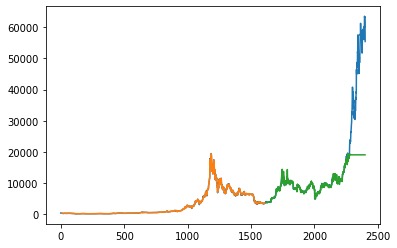

In [60]:
# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty(dataset.shape[0])
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory] = trainPredict

# y lo mismo para el test
testPredictPlot = numpy.empty(dataset.shape[0])
testPredictPlot[:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1] = testPredict

# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Entrenar usando un Walk-Forward Validation

In [69]:
import datetime as dt
from pandas_datareader import data

dataset_raw = data.DataReader('BTC-USD','yahoo', dt.datetime(2020,1,1), dt.datetime.now())
dataset_raw.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-01,7254.330566,7174.944336,7194.892090,7200.174316,1.856566e+10,7200.174316
2020-01-02,7212.155273,6935.270020,7202.551270,6985.470215,2.080208e+10,6985.470215
2020-01-03,7413.715332,6914.996094,6984.428711,7344.884277,2.811148e+10,7344.884277
2020-01-04,7427.385742,7309.514160,7345.375488,7410.656738,1.844427e+10,7410.656738
2020-01-05,7544.497070,7400.535645,7410.451660,7411.317383,1.972507e+10,7411.317383


In [71]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy
from tqdm import tqdm

def create_dataset(dataset, look_back_memory=1):
    data = []
    for i in range(len(dataset)-look_back_memory):
        data.append(dataset[i:i+look_back_memory+1, 0])
    return numpy.array(data)

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX, n_estimators):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_estimators=10):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in tqdm(range(len(test))):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX, n_estimators)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		# print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [72]:
# creamos el dataset como de costumbre
data = create_dataset(dataset_raw[['Close']].values, look_back_memory=10)
print(data.shape)

(460, 11)



  0%|          | 0/459 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +

100%|██████████| 459/459 [00:03<00:00, 122.27it/s]


MAE: 8034.595


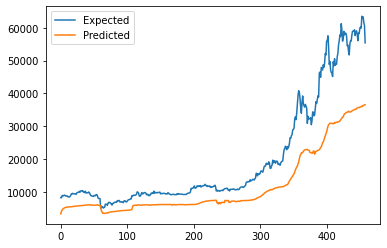

In [73]:
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test=459, n_estimators=10)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()


  0%|          | 0/459 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +

100%|██████████| 459/459 [00:14<00:00, 31.79it/s]


MAE: 765.085


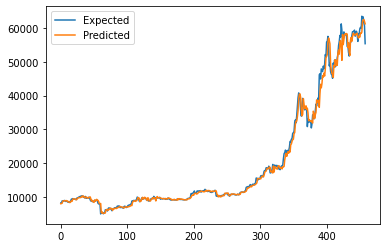

In [76]:
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test=459, n_estimators=100)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

Como podéis observar, la red es capaz de predecir bastante mejor los valores de cierre cuando utilizamos una ventana más grande.

¿Cómo podíarmos mejorar estos resultados?

¿Y si utilizamos, además del valor de cierre, el resto de valores?

## Predicción con más de una variable

En esta ocasión utilizaremos todos los datos que nos brinda la API de Yahoo para predecir el precio de cierre de una acción.

In [35]:
import datetime as dt
from pandas_datareader import data

dataset_raw = data.DataReader('BTC-USD','yahoo', dt.datetime(2020,1,1), dt.datetime.now())
dataset_raw.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-01,7254.330566,7174.944336,7194.892090,7200.174316,1.856566e+10,7200.174316
2020-01-02,7212.155273,6935.270020,7202.551270,6985.470215,2.080208e+10,6985.470215
2020-01-03,7413.715332,6914.996094,6984.428711,7344.884277,2.811148e+10,7344.884277
2020-01-04,7427.385742,7309.514160,7345.375488,7410.656738,1.844427e+10,7410.656738
2020-01-05,7544.497070,7400.535645,7410.451660,7411.317383,1.972507e+10,7411.317383


In [36]:
dataset_raw.values[0, :-1]

array([7.25433057e+03, 7.17494434e+03, 7.19489209e+03, 7.20017432e+03,
       1.85656650e+10])

In [37]:
dataset_raw.values[1, -1]

6985.47021484375

In [38]:
numpy.append(dataset_raw.values[0, :-1], dataset_raw.values[1, -1])

array([7.25433057e+03, 7.17494434e+03, 7.19489209e+03, 7.20017432e+03,
       1.85656650e+10, 6.98547021e+03])

In [39]:
def create_dataset(dataset):
    data = []
    for i in range(len(dataset)-1):
        data.append(numpy.append(dataset_raw.values[i, :-1], dataset_raw.values[i+1, -1]))
    return numpy.array(data)

data = create_dataset(dataset_raw.values)
print(data[:5])
print(data.shape)

[[7.25433057e+03 7.17494434e+03 7.19489209e+03 7.20017432e+03
  1.85656650e+10 6.98547021e+03]
 [7.21215527e+03 6.93527002e+03 7.20255127e+03 6.98547021e+03
  2.08020835e+10 7.34488428e+03]
 [7.41371533e+03 6.91499609e+03 6.98442871e+03 7.34488428e+03
  2.81114810e+10 7.41065674e+03]
 [7.42738574e+03 7.30951416e+03 7.34537549e+03 7.41065674e+03
  1.84442713e+10 7.41131738e+03]
 [7.54449707e+03 7.40053564e+03 7.41045166e+03 7.41131738e+03
  1.97250741e+10 7.76921924e+03]]
(469, 6)


In [40]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy
from tqdm import tqdm

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX, n_estimators):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0], model

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_estimators=10):
    predictions = list()
    models = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in tqdm(range(len(test))):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat, model = xgboost_forecast(history, testX, n_estimators)
        # store forecast in list of predictions
        predictions.append(yhat)
        models.append(model)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, models

In [41]:
# evaluate
mae, y, yhat, models = walk_forward_validation(data, n_test=1760, n_estimators=10)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

  0%|          | 0/469 [00:00<?, ?it/s]


IndexError: ignored

Obtenemos un error muy similar a cuando utilizamos solo el valor de cierre (Close). ¿A qué puede deberse esto?

Fijaos:

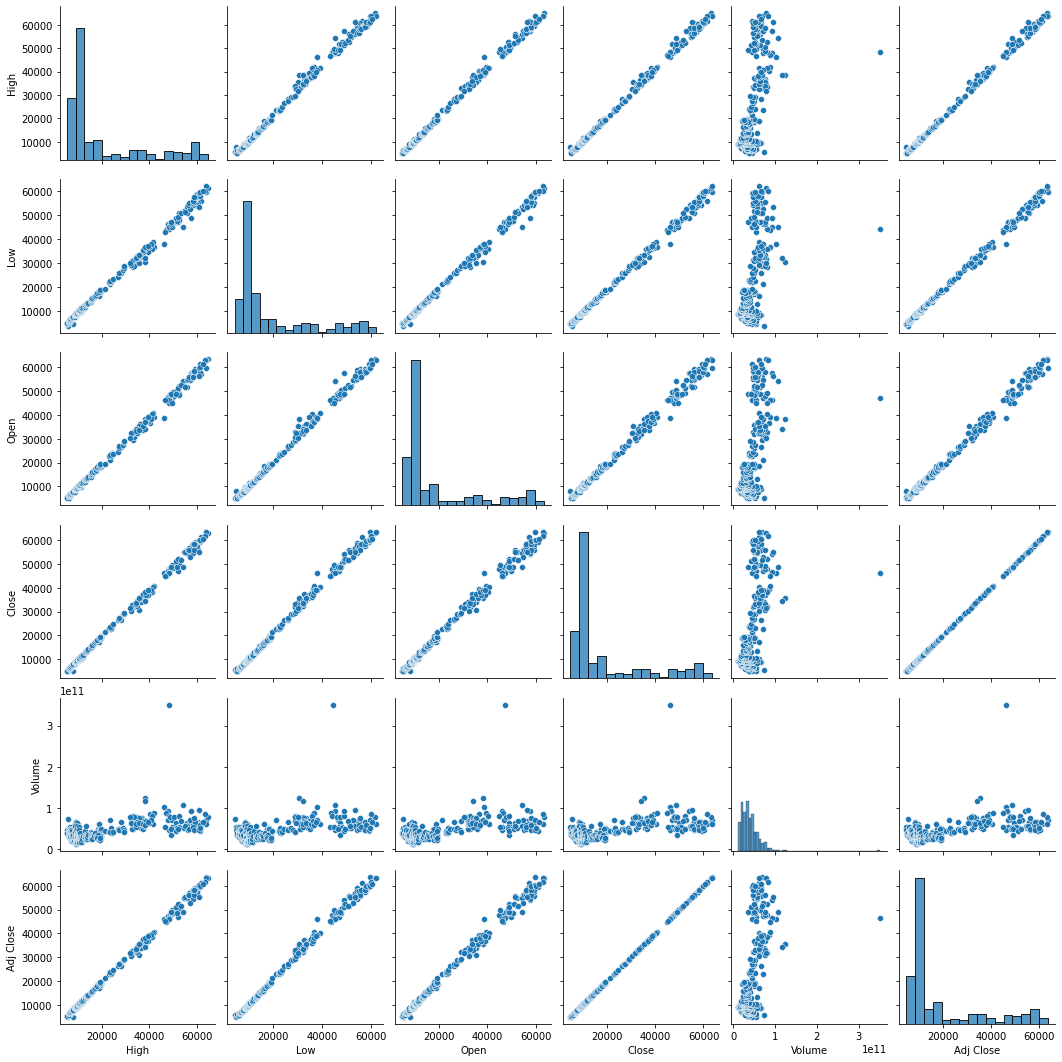

In [42]:
import seaborn as sns
sns.pairplot(dataset_raw)

Como podéis comprobar, las variables están muy correlacionadas entre sí, por lo que es normal que no aporten información al modelo.

Además, según con el modelo con el que trabajemos, podría incluso infuir negativamente.

Veamos la importancia de las variables obtenida por el XGBoost:

In [43]:
cols = dataset_raw.columns[:-1]
imps = numpy.stack([m.feature_importances_ for m in models])

NameError: ignored

In [ ]:
imps.shape

In [ ]:
feature_importances = DataFrame(imps, columns=cols)
# feature_importances = feature_importances.sort_values(by='imp',ascending=False)
# px.bar(feature_importances,x='col',y='imp')
feature_importances.describe()

Las variables High, Low, Close y Open tienen una importancia muy similar. Viendo las correlaciones, esto nos indica que son redundantes. Por otra parte, Volume no aporta nada.

**¿Y si hubiéramos normalizado?**

In [ ]:
def create_dataset(dataset):
    data = []
    for i in range(len(dataset)-1):
        data.append(numpy.append(dataset_raw.values[i, :-1], dataset_raw.values[i+1, -1]))
    return numpy.array(data)

data = create_dataset(dataset_raw.values)
print(data[:5])
print(data.shape)

In [ ]:
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data[:5]

In [ ]:
data.min(axis=0)

In [ ]:
data.max(axis=0)

In [ ]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy
from tqdm import tqdm

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX, n_estimators):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0], model

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_estimators=10):
    predictions = list()
    models = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in tqdm(range(len(test))):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat, model = xgboost_forecast(history, testX, n_estimators)
        # store forecast in list of predictions
        predictions.append(yhat)
        models.append(model)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, models

In [ ]:
# evaluate
mae, y, yhat, models = walk_forward_validation(data, n_test=1760, n_estimators=10)
print('MAE: %.3f' % mae)

# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
cols = dataset_raw.columns[:-1]
imps = numpy.stack([m.feature_importances_ for m in models])

In [ ]:
feature_importances = DataFrame(imps, columns=cols)
feature_importances.describe()

Fijaos que el ajuste es mejor, pero sigue sin tener en cuenta la variable Volume para nada.

**Más ejemplos interesantes de predicción con XGBoost**

- Predicción de compras

https://www.kaggle.com/alessandrosolbiati/using-xgboost-for-time-series-prediction-top-20

- Nacimientos de niñas

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

- Consumo de energía eléctrica

https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

https://github.com/Jenniferz28/Time-Series-ARIMA-XGBOOST-RNN

- Predicción de la demanda de bicicletas:

https://towardsdatascience.com/go-highly-accurate-or-go-home-61828afb0b13

**Más datasets** 

https://archive.ics.uci.edu/ml/index.php

